In [1]:
import numpy as np
from numpy import random
import scipy as sp

import anndata as ad
from scanpy.api.tl import umap
from scanpy.api import pp
import matplotlib.pyplot as plt

In [2]:
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from prosstt import count_model as cmod

Define a palette with enough colors to visualize the tree.

In [3]:
palette = np.array(['#e6194b', '#3cb44b', '#ffe119', '#4363d8',
                    '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                    '#bcf60c', '#fabebe', '#008080', '#e6beff',
                    '#9a6324', '#fffac8', '#800000', '#aaffc3',
                    '#808000', '#ffd8b1', '#000075', '#808080',])

Set random seed for reproducibility.

In [4]:
rseed = 42
np.random.seed(rseed)

Define a tree with 5 bifurcations:

In [5]:
num_brpoints = 5
top = tree.Tree.gen_random_topology(num_brpoints)

branches = np.unique(np.array(top).flatten())
num_branches = 2 * num_brpoints + 1
time = {b: 50 for b in branches}
modules = 5 * num_brpoints + np.random.randint(3, 20)
G = 500

t = tree.Tree(topology=top, time=time, num_branches=num_branches,
              G=G, branch_points=num_brpoints, modules=modules)

Set an appropriate _a_ value for the module contributions and simulate gene expression change:

In [6]:
mya = np.min([0.05, 1 / t.modules])

In [7]:
uMs, Ws, Hs = sim.simulate_lineage(t, a=mya, intra_branch_tol=-1, inter_branch_tol=0)

/home/soedinglaptop/miniconda3/envs/py37/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Scale by base gene expression

In [8]:
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

Sample variance hyperparameters:

In [9]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

Now sample in various modes, perform dimensionality reduction and plot the result.

 First sample each position on the tree twice:

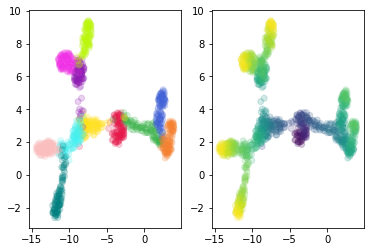

In [10]:
X1, labs1, brns1, scalings1 = sim.sample_whole_tree(t, 2, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

data1 = ad.AnnData(np.log(X1+1))
pp.neighbors(data1, use_rep='X', n_neighbors=int(X1.shape[0] / 2))
umap(data1)
dm1 = data1.obsm["X_umap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
ax[0].scatter(dm1[:, 0], dm1[:, 1], c=palette[indices1], alpha=0.2)
ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1, alpha=0.2)

Sample at equidistant pseudotime points:

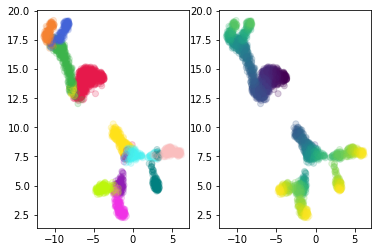

In [11]:
spaced_sample_times = np.arange(0, t.get_max_time(), 5)
spaced_times = np.repeat(spaced_sample_times, 50)

X2, labs2, brns2, scalings2 = sim._sample_data_at_times(t, spaced_times, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

data2 = ad.AnnData(np.log(X2+1))
pp.neighbors(data2, use_rep='X', n_neighbors=700)
umap(data2)
dm2 = data2.obsm["X_umap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm2[:, 0], dm2[:, 1], c=palette[indices2], alpha=0.2)
ax[1].scatter(dm2[:, 0], dm2[:, 1], c=labs2, alpha=0.2)

change variance parameters so that the counts are Poisson-distributed and sample the whole tree:

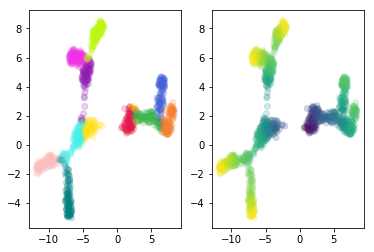

In [12]:
alpha3 = np.exp(random.normal(loc=np.log(0.0001), scale=np.log(1), size=t.G))
beta3 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

X3, labs3, brns3, scalings3 = sim.sample_whole_tree(t, 2, alpha=alpha3, beta=beta3)

# normalize gene expression by library size
X3 = (X3.transpose() / scalings3).transpose()

data3 = ad.AnnData(np.log(X3+1))
pp.neighbors(data3, use_rep='X', n_neighbors=250)
umap(data3)
dm3 = data3.obsm["X_umap"]
br_names3, indices3 = np.unique(brns3, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm3[:, 0], dm3[:, 1], c=palette[indices3], alpha=0.2)
ax[1].scatter(dm3[:, 0], dm3[:, 1], c=labs3, alpha=0.2)